</p>

<p>-adding custom schedule [improved learning]</p>
<p>-adjusting hyperparameters, d_model =100, droprate =  0.2</p>
<p>-adding attention weights to output for viz </p>
<p>-loading saved model for salient map </p>


<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

## Setup

In [16]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Navigate to the Directory Containing the CSV File
import os
os.chdir('/content/drive/My Drive/DS266 Project')

Begin by installing [TensorFlow Datasets](https://tensorflow.org/datasets) for loading the dataset and [TensorFlow Text](https://www.tensorflow.org/text) for text preprocessing:

In [18]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install -q --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists...
Building dependency tree...
Reading state information...
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.


In [19]:
# Install compatible TensorFlow version
!pip uninstall tensorflow -y -q
!pip install tensorflow==2.15 -q

# Reinstall tf-keras to resolve any potential dependency conflicts
!pip uninstall tf-keras -y -q
!pip install tf-keras -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.15.0 which is incompatible.


Import the necessary modules:

In [20]:
!pip install -q tensorflow==2.15

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.15.0 which is incompatible.
tf-keras 2.16.0 requires tensorflow<2.17,>=2.16, but you have tensorflow 2.15.0 which is incompatible.


In [21]:
!pip uninstall tensorflow-text -y -q
!pip install tensorflow-text==2.15 -q

In [22]:
import logging
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_text as text
from tensorflow import keras

## Data handling



###Load the dataset

Load the data the model your loading was trained on:

In [23]:
# Read the CSV File
import pandas as pd
tweets_df = pd.read_csv('train_enhanced_cleaned.csv')
tweets_df.head(3)
bl_tweets_df = pd.read_csv('train.csv')

In [24]:
sentences = tweets_df['text']
labels = tweets_df['target']
bl_sentences = bl_tweets_df['text']
bl_labels = bl_tweets_df['target']

####Define val_data and val_labels

In [25]:
from sklearn.model_selection import train_test_split
# Shuffle and batch the dataset


# Split the data
train_data, val_data, train_labels, val_labels = train_test_split(sentences, labels, test_size=0.3)
bl_train_data, bl_val_data, bl_train_labels, bl_val_labels = train_test_split(bl_sentences, bl_labels, test_size=0.3)

In [26]:
 val_data.shape,type(val_data)

((2284,), pandas.core.series.Series)

### Set up the tokenizer

Now that you have loaded the dataset, you need to tokenize the text, so that each element is represented as a [token](https://developers.google.com/machine-learning/glossary#token) or token ID (a numeric representation).

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Instantiate the tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on your text data
tokenizer.fit_on_texts(sentences)


In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Instantiate the tokenizer
bl_tokenizer = Tokenizer()

# Fit the tokenizer on your text data
bl_tokenizer.fit_on_texts(bl_sentences)

In [29]:
MAX_TOKENS =30
# Convert sentences to sequences
sequences = tokenizer.texts_to_sequences(sentences)

# Pad sequences
sequences = pad_sequences(sequences, maxlen=MAX_TOKENS, padding='post')

# Convert labels to NumPy array
labels = labels.to_numpy()


In [30]:
MAX_TOKENS =30
# Convert sentences to sequences
bl_sequences = bl_tokenizer.texts_to_sequences(bl_sentences)

# Pad sequences
bl_sequences = pad_sequences(bl_sequences, maxlen=MAX_TOKENS, padding='post')

# Convert labels to NumPy array
bl_labels = bl_labels.to_numpy()

In [31]:
print ("original text: ")
for i in range(3):

  print(tweets_df.text.iloc[i])
print ("tokenized text: ")
for i in range(3):
  print(sequences[i])

original text: 
location   our deeds are the reason of this earthquake may allah forgive us all negative  news   social concern non irony optimism 
location   forest fire near la ronge sask  canada neutral  news   social concern non irony fear 
location   all residents asked to shelter in place are being notified by officers  no other evacuation or shelter in place orders are expected neutral  news   social concern non irony disgust 
tokenized text: 
[   4  142 4574   38    9  883   14   34  160  161 1634 4575  115   61
   10    1    2    3    6    5   58    0    0    0    0    0    0    0
    0    0]
[   4  118   42  420  815 6846 6847 1408    8    1    2    3    6    5
   15    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[   4   61 1758 1635   13 1945   12  710   38  158 6848   33 1759   56
  553  172   78 1945   12  710 1409   38 1126    8    1    2    3    6
    5   21]


The distribution of tokens per example in the dataset is as follows:

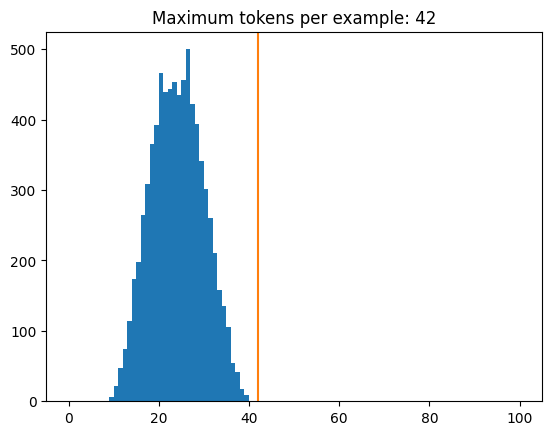

In [32]:


# Tokenize the sentences
tokenized_sentences = tokenizer.texts_to_sequences(tweets_df['text'])

# Calculate the lengths of the tokenized sentences
lengths = [len(sentence) for sentence in tokenized_sentences]

# Plot the histogram of lengths
plt.hist(lengths, np.linspace(0, 100, 101))
plt.ylim(plt.ylim())
max_length = max(lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');


In [33]:
#convert sequence back to text
def sequence_to_text(sequence):
    # Convert a sequence of indices to text using the tokenizer's index_word dictionary
    return ' '.join([tokenizer.index_word.get(index, '') for index in sequence])



Convert back to English words

In [34]:
# Convert the sequence to text
text = sequence_to_text(sequences[0])
print(text)
print(labels[0])

location our deeds are the reason of this earthquake may allah forgive us all negative news social concern non irony optimism         
1


### Set up a data pipeline with `tf.data`

The following function takes batches of text as input, and converts them to a format suitable for training.

1. It tokenizes them into ragged batches.
2. It trims each to be no longer than `MAX_TOKENS`.
3. It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the `label` is the id of the next token.
4. It converts the `RaggedTensor`s to padded dense `Tensor`s.
5. It returns an `(inputs, labels)` pair.


In [35]:
from sklearn.model_selection import train_test_split
# Shuffle and batch the dataset
BUFFER_SIZE = len(sequences)
BATCH_SIZE = 64  # You can adjust the batch size as needed

# Split the data
sequences_train, sequences_val, labels_train, labels_val = train_test_split(sequences, labels, test_size=0.3)

# Convert to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((sequences_train, labels_train))
val_dataset = tf.data.Dataset.from_tensor_slices((sequences_val, labels_val))

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(len(sequences_train)).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)




Sanity check the dataset

In [36]:
for tweet, labels in train_dataset.take(1):
  break

print(tweet.shape)
print(labels.shape)


(64, 30)
(64,)


In [37]:
tweet[0]

<tf.Tensor: shape=(30,), dtype=int32, numpy=
array([   14,   115,   127,     9,  1858,    66,    41,    26,     9,
         526,    14,   329,   517,   115,   270,     9, 17333, 17334,
          98,  1748,    11,   300,    72,    10,     1,     2,     3,
           6,     5,    54], dtype=int32)>

## The Transformer Classifier

#### The Classifier Transformer Architecture Along with its Components

This classifier model is based on last hidden state

In [38]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

"""
The position encoding function is a stack of sines and cosines that vibrate at different frequencies depending on their location
along the depth of the embedding vector. They vibrate across the position axis.
"""
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)
    #the line below is new
    #self.pos_encoding = tf.cast(self.pos_encoding, tf.float64)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    #x, _ = x #ignore attn weights
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    #x *= tf.math.sqrt(tf.cast(self.d_model, tf.float64))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    #print("positionalembedding: shape and type:")
    #the casting is new
    #x = tf.cast(x, tf.float64)
    #print(x.dtype)
    #print(tf.shape(x)[1])
    return x

"""The base attention layer"""
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

"""The global attention layer"""
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output, attn_scores = self.mha(
        query=x,
        value=x,
        key=x,
        return_attention_scores=True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    return x

"""The feed forward layer"""
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

"""The Encoder Layer"""

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):

    #print(f"Shape of inputs to encoder layer: {x.shape}")  # Add this line
    x = self.self_attention(x)
    #print(f"Shape after self_attention: {x.shape}")  # Add this line

    x = self.ffn(x)
    return x

  @property
  def last_attn_scores(self):
    return self.self_attention.last_attn_scores

"""The Encoder"""

class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    #print(f"Shape of inputs to encoder: {x.shape}")  # Add this line
    x = self.pos_embedding(x)
    #print(f"Shape after pos_embedding: {x.shape}")  # Add this line


    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    #print("length: ", x.dtype)
    return x  # Shape `(batch_size, seq_len, d_model)`.


  @property
  def last_attn_scores(self):
    return self.enc_layers[-1].last_attn_scores


"""Finally the Transformer Class"""
class TransformerClassifier(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context = inputs
    #print(f"Shape of inputs to transformer: {inputs.shape}")  # Add this line
    #print(f"Shape of inputs to transformer: {inputs.dtype}")  # Add this line
    #print((f"end printing shapes and type of input"))

    context = self.encoder(context)  # (batch_size, context_len, d_model)
    logits = self.final_layer(context[:, -1, :])  # Use the last hidden state
    #print(f"end transformer")  # Add this line
    return logits





To keep this example small and relatively fast, the number of layers (`num_layers`), the dimensionality of the embeddings (`d_model`), and the internal dimensionality of the `FeedForward` layer (`dff`) have been reduced.

The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`.

The number of self-attention heads remains the same (`num_heads=8`).


##Lets have some fun

####Load the trained model

At this point we have defined the transformerclassifier class and all its dependencies per above.

Learnable Positional Encoding Model

In [39]:
#change file path appropiately
checkpoint_dir = './Final_Work/lp_plus_attn_enh_cl_more_lp_tx_2h_2l_tweet_emb_d06_dff256_ep12/'
lp_model_name = 'lp_plus_attn_cl_enh_more_dat_tx_w_tweet_2h12l_ep12_d06_dff256.10-0.82'
lp_checkpoint_filepath = checkpoint_dir + lp_model_name



Final Base Transformer Model

In [40]:
#change file path appropiately
checkpoint_dir = './Final_Work/enh_clean_more_bl_tx_2_h_2l_twitter_emb_highdrop_low_dff/'
tx_model_name = 'cl_enh_more_dat_bl_tx_w_tw_embed_2h_2l_20ep_drophigh_low_dff.06-0.84'
tx_checkpoint_filepath = checkpoint_dir + tx_model_name


Baseline model with baseline data

In [41]:
#change file path appropiately
checkpoint_dir = './model_checkpoints/'
bl_model_name = 'tx_w_embeddings_cl2a.06-0.79'
bl_checkpoint_filepath = checkpoint_dir + bl_model_name

#### Hyperparameters

For PL and Final Tx model are the same

In [42]:
#use same num_heads, num_layers, d_model, dff that model was built with
#for loading
num_layers = 2
d_model = 100
dff = 256
num_heads = 2
dropout_rate = 0.6
MAX_TOKENS =30

For baseline model its different

In [43]:
#use same num_heads, num_layers, d_model, dff that model was built with
#for loading
bl_num_layers = 2
bl_d_model = 100
bl_dff = 512
bl_num_heads = 8
bl_dropout_rate = 0.3
bl_MAX_TOKENS =30

In [44]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
sentences2 = tweets_df['text']
labels2 = tweets_df['target']

# Instantiate the tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on your text data
tokenizer.fit_on_texts(sentences)

In [45]:
# Create a new instance of the model
lp_model = TransformerClassifier(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size= len(tokenizer.word_index) + 1,
    dropout_rate=dropout_rate)

# Build the model by calling it on some data
#remember to define tweet

lp_model(tweet)

# Now load the weights
lp_model.load_weights(lp_checkpoint_filepath)


In [46]:
# Create a new instance of the model
tx_model = TransformerClassifier(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size= len(tokenizer.word_index) + 1,
    dropout_rate=dropout_rate)

# Build the model by calling it on some data
#remember to define tweet

tx_model(tweet)

# Now load the weights
tx_model.load_weights(tx_checkpoint_filepath)

In [47]:
# Create a new instance of the model
bl_model = TransformerClassifier(
    num_layers=bl_num_layers,
    d_model=bl_d_model,
    num_heads=bl_num_heads,
    dff=bl_dff,
    input_vocab_size= len(bl_tokenizer.word_index) + 1,
    dropout_rate=bl_dropout_rate)

# Build the model by calling it on some data
#remember to define tweet

bl_model(tweet)

# Now load the weights
bl_model.load_weights(bl_checkpoint_filepath)

##Analysis and Diagnostics

###Supporting Functions
###Classification

In [48]:

def classification(prediction):


  t ='''
        TRUE TRUE TRUE TRUE TRUE TRUE
        TRUE TRUE TRUE TRUE TRUE TRUE
        TRUE TRUE TRUE TRUE TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE'''

  f = '''
         FALSE FALSE FALSE FALSE
         FALSE FALSE FALSE FALSE
         FALSE
         FALSE
         FALSE FALSE FALSE FALSE
         FALSEFALSE FALSE FALSE
         FALSE
         FALSE
         FALSE
         FALSE
         FALSE'''

  class_names = [f, t]
  # Since this is a binary classification,round the prediction to the nearest integer (0 or 1)
  print('probability of true: ', prediction[0])
  rounded_predictions = np.round(prediction[0])

  # Now, you can use this rounded prediction to index into your class_names
  predicted_class = class_names[int(rounded_predictions[0])]

  print(predicted_class)


In [49]:
@tf.function
def forward_and_get_attn_scores(input, model):
    # Forward pass on your model
    output = model(input)

    # Get attention scores
    attn_scores = model.encoder.last_attn_scores
    #prediction = transformer.predict(input)
    return output, attn_scores




###Format Sentence: Tokenize

In [50]:
import string
def format_sentence(text, max_sentence_length=30):

    #print('original sentence: ', text)

    # Lowercase the text
    text = text.lower()

  # Remove punctuation

    text = text.translate(str.maketrans('', '', string.punctuation))


    #print('untokenized sentence: ', text)

    MAX_TOKENS =max_sentence_length
    # Convert sentences to sequences
    sequences2 = tokenizer.texts_to_sequences([text])
    #print("len: ", len(sequences2))
    # Pad sequences
    sequences2 = pad_sequences(sequences2, maxlen=MAX_TOKENS, padding='post')

    #print('tokenized sentence: ', sequences2)
    #print('vector of first word: ', vectorized_sentences[0, 0])

    return sequences2


###Convert Tokenized Sentences Back to Word

In [51]:
def sequences_to_text(sequences, tokenizer):
    # Retrieve the index_word mapping from the tokenizer
    index_word = tokenizer.index_word
    # Initialize an empty list to store the converted sentences
    text_sentences = []
    # Iterate over each sequence
    for seq in sequences:
        # Convert each token in the sequence back to the corresponding word
        words = [index_word.get(i, 'UNK') for i in seq if i != 0]
        # Join the words to form the sentence
        sentence = ' '.join(words)
        # Append the sentence to the list
        text_sentences.append(sentence)
    return text_sentences




####Classification Execution

In [52]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Ensure val_data is a Series of strings
val_data = val_data.astype(str)

# Instantiate the tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on your text data
#tokenizer.fit_on_texts(val_data)
#tokenized_sentences = tokenizer.texts_to_sequences(tweets_df['text'])
sentences = tweets_df['text']
tokenizer.fit_on_texts(sentences)

MAX_TOKENS = 30
# Convert sentences to sequences
sequences = tokenizer.texts_to_sequences(val_data)

# Pad sequences
sequences = pad_sequences(sequences, maxlen=MAX_TOKENS, padding='post')

# Convert labels to NumPy array if they aren't already
if not isinstance(val_labels, np.ndarray):
    val_labels = val_labels.to_numpy()





###Get Results

In [ ]:
from sklearn.metrics import confusion_matrix


bl_predictions = bl_model.predict(sequences)
bl_rounded_predictions = np.round(bl_predictions)

# Calculate confusion matrix
bl_cm = confusion_matrix(val_labels, bl_rounded_predictions)

# Confusion matrix format:
# [[true_negatives, false_positives],
#  [false_negatives, true_positives]]

# Extract false positives
bl_false_positives = bl_cm[0][1] if bl_cm.shape == (2, 2) else 0
bl_false_negatives = bl_cm[1][0] if bl_cm.shape == (2, 2) else 0
bl_true_negatives = bl_cm[0][0] if bl_cm.shape == (2, 2) else 0
bl_rue_positives = bl_cm[1][1] if bl_cm.shape == (2, 2) else 0

print("bl_model: ")
print(f'Number of false positives: {bl_false_positives}')
print(f'Number of false negatives: {bl_false_negatives}')

tx_predictions = tx_model.predict(sequences)
tx_rounded_predictions = np.round(tx_predictions)

# Calculate confusion matrix
tx_cm = confusion_matrix(val_labels, tx_rounded_predictions)

# Confusion matrix format:
# [[true_negatives, false_positives],
#  [false_negatives, true_positives]]

# Extract false positives
tx_false_positives = tx_cm[0][1] if tx_cm.shape == (2, 2) else 0
tx_false_negatives = tx_cm[1][0] if tx_cm.shape == (2, 2) else 0
tx_true_negatives = tx_cm[0][0] if tx_cm.shape == (2, 2) else 0
tx_true_positives = tx_cm[1][1] if tx_cm.shape == (2, 2) else 0

print("tx_model: ")
print(f'Number of false positives: {tx_false_positives}')
print(f'Number of false negatives: {tx_false_negatives}')

lp_predictions = lp_model.predict(sequences)
lp_rounded_predictions = np.round(lp_predictions)

# Calculate confusion matrix
lp_cm = confusion_matrix(val_labels, lp_rounded_predictions)

# Confusion matrix format:
# [[true_negatives, false_positives],
#  [false_negatives, true_positives]]

# Extract false positives
lp_false_positives = lp_cm[0][1] if lp_cm.shape == (2, 2) else 0
lp_false_negatives = lp_cm[1][0] if lp_cm.shape == (2, 2) else 0
lp_true_negatives = lp_cm[0][0] if lp_cm.shape == (2, 2) else 0
lp_true_positives = lp_cm[1][1] if lp_cm.shape == (2, 2) else 0

print("lp_model: ")
print(f'Number of false positives: {lp_false_positives}')
print(f'Number of false negatives: {lp_false_negatives}')




72/72 [==============================] - 2s 21ms/step
bl_model: 
Number of false positives: 28
Number of false negatives: 978
72/72 [==============================] - 1s 21ms/step
tx_model: 
Number of false positives: 145
Number of false negatives: 288
72/72 [==============================] - 1s 21ms/step
lp_model: 
Number of false positives: 154
Number of false negatives: 202


####Confusion Matrix

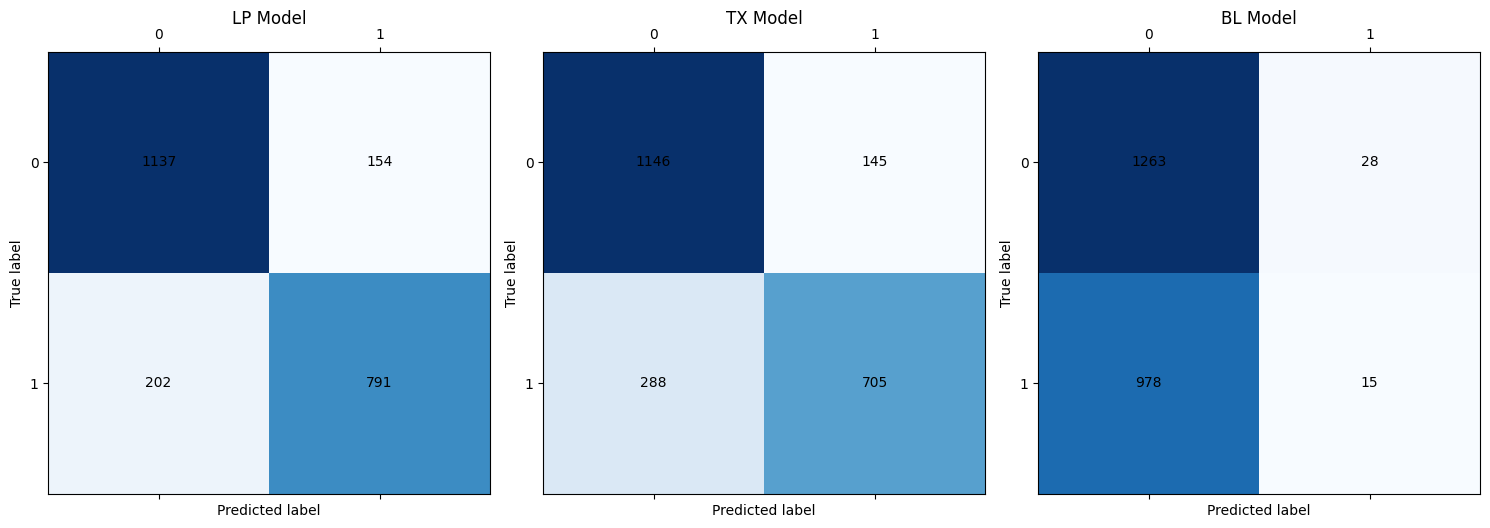

In [ ]:
# Function to plot a confusion matrix
def plot_confusion_matrix(cm, title, subtitle, ax):
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    ax.set_title(subtitle, pad=20)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    # Loop over data dimensions and create text annotations.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot each confusion matrix with subtitles
plot_confusion_matrix(lp_cm, 'LP Model Confusion Matrix', 'LP Model', axes[0])
plot_confusion_matrix(tx_cm, 'TX Model Confusion Matrix', 'TX Model', axes[1])
plot_confusion_matrix(bl_cm, 'BL Model Confusion Matrix', 'BL Model', axes[2])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

we will focus on the differences between the tx_model and the lp_model

####False Positives

I want to extract the top ten shortest sentencs that produced the false positives

lp_model

In [ ]:
import pandas as pd


false_positive_indices = np.where((lp_rounded_predictions == 1) & (val_labels == 0))[0]

# Extract the sentences corresponding to false positives
false_positive_sentences = val_data.iloc[false_positive_indices]

# Create a DataFrame to sort sentences by length
lp_fp_sentences_df = pd.DataFrame({
    'sentence': false_positive_sentences,
    'length': false_positive_sentences.apply(len)
})

# Drop duplicates to ensure unique sentences
lp_fp_sentences_df = lp_fp_sentences_df.drop_duplicates(subset='sentence')

# Sort by sentence length and get the top ten shortest sentences
lp_top_ten_shortest_fp = lp_fp_sentences_df.sort_values(by='length', ascending=True).head(20)

# Print the results
print(lp_top_ten_shortest_fp)


                                               sentence  length
3054  location earthquake earthquake drill atm neutr...      87
3496  location explosion kindermorgan gas explosion ...      89
630   location bioterrorism to fight bioterrorism si...      91
7469  location wreck captainn morgan car wreck  neut...      91
3351  location evacuated rocky fire weblink   neutra...      94
4095  location hail weathernetwork here comes the ha...      95
3757  location fire wcw catsandsyrup tha bitch is fi...      97
1391  location bush fires the bush fires in ca are s...      98
3330  location evacuated they evacuated the mall  ag...      98
1269  location burned wild lionx3 so others dont get...     100
7149  location volcano lexi purduee the volcano by i...     103
7313  location wild fires these wild fires out west ...     103
165   location airplane accident i had a airplane ac...     104
6742  location tornado soonergrunt better than torna...     104
6278  location storm johngreen storm and

tx_model

In [ ]:
import pandas as pd


false_positive_indices = np.where((tx_rounded_predictions == 1) & (val_labels == 0))[0]

# Extract the sentences corresponding to false positives
false_positive_sentences = val_data.iloc[false_positive_indices]

# Create a DataFrame to sort sentences by length
tx_fp_sentences_df = pd.DataFrame({
    'sentence': false_positive_sentences,
    'length': false_positive_sentences.apply(len)
})

# Drop duplicates to ensure unique sentences
tx_fp_sentences_df = tx_fp_sentences_df.drop_duplicates(subset='sentence')

# Sort by sentence length and get the top ten shortest sentences
tx_top_ten_shortest_fp = tx_fp_sentences_df.sort_values(by='length', ascending=True).head(10)

# Print the results
print(tx_top_ten_shortest_fp)


                                               sentence  length
3608  location fatal fatal attraction neutral  news ...      77
3054  location earthquake earthquake drill atm neutr...      87
6766  location tornado ayshun tornado then dont neut...      88
3351  location evacuated rocky fire weblink   neutra...      94
6071  location sinkhole damn that sinkhole on sunset...      97
1391  location bush fires the bush fires in ca are s...      98
3330  location evacuated they evacuated the mall  ag...      98
73    location accident bigrigradio live accident aw...     100
7313  location wild fires these wild fires out west ...     103
165   location airplane accident i had a airplane ac...     104


####False Negatives

I want to extract the top ten shortest sentencs that produced the false negatives

lp_model

In [ ]:
import pandas as pd


false_negative_indices = np.where((rounded_predictions == 0) & (val_labels == 1))[0]

# Extract the sentences corresponding to false negatives
false_negative_sentences = val_data.iloc[false_negative_indices]

# Create a DataFrame to sort sentences by length
lp_fn_sentences_df = pd.DataFrame({
    'sentence': false_negative_sentences,
    'length': false_negative_sentences.apply(len)
})

# Drop duplicates to ensure unique sentences
lp_fn_sentences_df = lp_fn_sentences_df.drop_duplicates(subset='sentence')

# Sort by sentence length and get the top ten shortest sentences
lp_top_ten_shortest_fn = lp_fn_sentences_df.sort_values(by='length', ascending=True).head(60)

# Print the results
print(lp_top_ten_shortest_fn)


                                               sentence  length
28    location   cooool  positive  news   social con...      61
24    location   looooool neutral  news   social con...      65
21    location   london is cool  positive  news   so...      69
17    location   summer is lovely positive  news   s...      70
6705  location thunder thunder neutral  news   socia...      71
18    location   my car is so fast positive  news   ...      71
3749  location fire i see fire neutral  news   socia...      71
1882  location crushed crushed neutral  news   socia...      74
3608  location fatal fatal attraction neutral  news ...      77
26    location   was in nyc last week neutral  news ...      77
2496  location desolate eggs desolate negative  news...      78
4922  location mayhem mayhem is beautiful positive  ...      78
3688  location fatality fatality https  neutral  new...      79
4184  location hazard get that hazard pay neutral  n...      79
4092  location hail hail pic ûó https  

tx_model

In [ ]:
import pandas as pd


false_negative_indices = np.where((rounded_predictions == 0) & (val_labels == 1))[0]

# Extract the sentences corresponding to false negatives
false_negative_sentences = val_data.iloc[false_negative_indices]

# Create a DataFrame to sort sentences by length
tx_fn_sentences_df = pd.DataFrame({
    'sentence': false_negative_sentences,
    'length': false_negative_sentences.apply(len)
})

# Drop duplicates to ensure unique sentences
tx_fn_sentences_df = tx_fn_sentences_df.drop_duplicates(subset='sentence')

# Sort by sentence length and get the top ten shortest sentences
tx_top_ten_shortest_fn = tx_fn_sentences_df.sort_values(by='length', ascending=True).head(60)

# Print the results
print(top_ten_shortest_fn)


                                               sentence  length
28    location   cooool  positive  news   social con...      61
24    location   looooool neutral  news   social con...      65
21    location   london is cool  positive  news   so...      69
17    location   summer is lovely positive  news   s...      70
6705  location thunder thunder neutral  news   socia...      71
18    location   my car is so fast positive  news   ...      71
3749  location fire i see fire neutral  news   socia...      71
1882  location crushed crushed neutral  news   socia...      74
3608  location fatal fatal attraction neutral  news ...      77
26    location   was in nyc last week neutral  news ...      77
2496  location desolate eggs desolate negative  news...      78
4922  location mayhem mayhem is beautiful positive  ...      78
3688  location fatality fatality https  neutral  new...      79
4184  location hazard get that hazard pay neutral  n...      79
4092  location hail hail pic ûó https  

###Salient Maps

####Attention Sentence Confusion Matrix per Head

Lighter color represents more attention given by the transformer

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_scores(attn_scores, sentence, title ='None'):
    # Assuming attn_scores is of shape (1, num_heads, seq_len, seq_len)
    num_heads = attn_scores.shape[1]
    seq_len = attn_scores.shape[2]

    # Reshape attention scores to (num_heads, seq_len, seq_len)
    attn_scores1 = np.squeeze(attn_scores, axis=0)

    # Split the sentence into words
    words = sentence.split()

    # Get the length of the sentence
    sentence_length = len(words)

    # Slice the attention scores to match the sentence length
    attn_scores1 = attn_scores1[:, :sentence_length, :sentence_length]

    # Plotting
    fig, axs = plt.subplots(1, num_heads, figsize=(10, 5))  # Change to 1 row and num_heads columns
    if title != 'None':
        fig.suptitle(title)  # Set the title for the plot
    for i in range(num_heads):
        axs[i].imshow(attn_scores1[i], cmap='viridis')
        axs[i].set_title(f'Head {i+1}')
        axs[i].set_xticks(np.arange(sentence_length))
        axs[i].set_yticks(np.arange(sentence_length))  # Set y-ticks
        axs[i].set_xticklabels(words, rotation=90)
        axs[i].set_yticklabels(words)  # Set y-tick labels
    plt.tight_layout()
    plt.show()

# Now you can call the function with attn_scores and sentence as arguments
# plot_attention_scores(attn_scores, "This is a real tragedy")






The below sentence is classified as true by tx_model although its labeled false

In [ ]:
tx_top_ten_shortest_fp.sentence.iloc[0]

'location fatal fatal attraction neutral  news   social concern irony sadness '

tx_model

['location fatal fatal attraction neutral news social concern irony sadness']
location fatal fatal attraction neutral  news   social concern irony sadness 
probability of true:  tf.Tensor([0.62583786], shape=(1,), dtype=float32)

        TRUE TRUE TRUE TRUE TRUE TRUE
        TRUE TRUE TRUE TRUE TRUE TRUE
        TRUE TRUE TRUE TRUE TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE


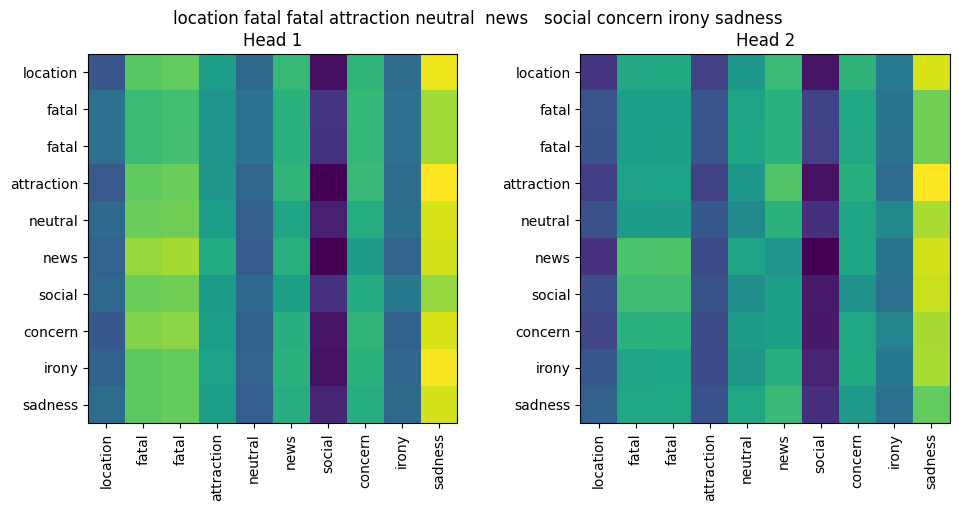

In [ ]:
i=0
original_sentence = tx_top_ten_shortest_fp.sentence.iloc[i]
text_sentences = sequences_to_text(format_sentence(original_sentence), tokenizer)
print(text_sentences)
text_sentences[0]
print(original_sentence)
prediction, attn_scores = forward_and_get_attn_scores(format_sentence(original_sentence), tx_model)
classification(prediction)
plot_attention_scores(attn_scores, text_sentences[0], original_sentence)

The lp_model classifies it correctly

['location fatal fatal attraction neutral news social concern irony sadness']
location fatal fatal attraction neutral  news   social concern irony sadness 
probability of true:  tf.Tensor([0.41652828], shape=(1,), dtype=float32)

         FALSE FALSE FALSE FALSE
         FALSE FALSE FALSE FALSE
         FALSE
         FALSE
         FALSE FALSE FALSE FALSE
         FALSEFALSE FALSE FALSE
         FALSE
         FALSE
         FALSE
         FALSE
         FALSE


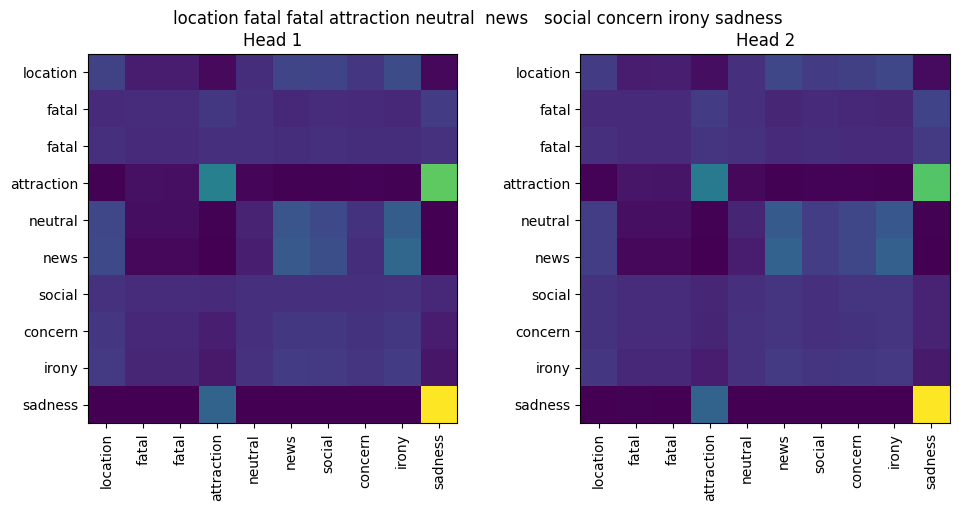

In [ ]:
i=0
original_sentence = tx_top_ten_shortest_fp.sentence.iloc[i]
text_sentences = sequences_to_text(format_sentence(original_sentence), tokenizer)
print(text_sentences)
text_sentences[0]
print(original_sentence)
prediction, attn_scores = forward_and_get_attn_scores(format_sentence(original_sentence), lp_model)
classification(prediction)
plot_attention_scores(attn_scores, text_sentences[0], original_sentence)

In the above, the lp_model has learned to pay special attention to attraction

In "blew up those mentions" we want to see the relationship between "blew" "up" and "mentions"

tx_model

['blew up those mentions']
blew up those mentions
probability of true:  tf.Tensor([0.03049658], shape=(1,), dtype=float32)

         FALSE FALSE FALSE FALSE
         FALSE FALSE FALSE FALSE
         FALSE
         FALSE
         FALSE FALSE FALSE FALSE
         FALSEFALSE FALSE FALSE
         FALSE
         FALSE
         FALSE
         FALSE
         FALSE


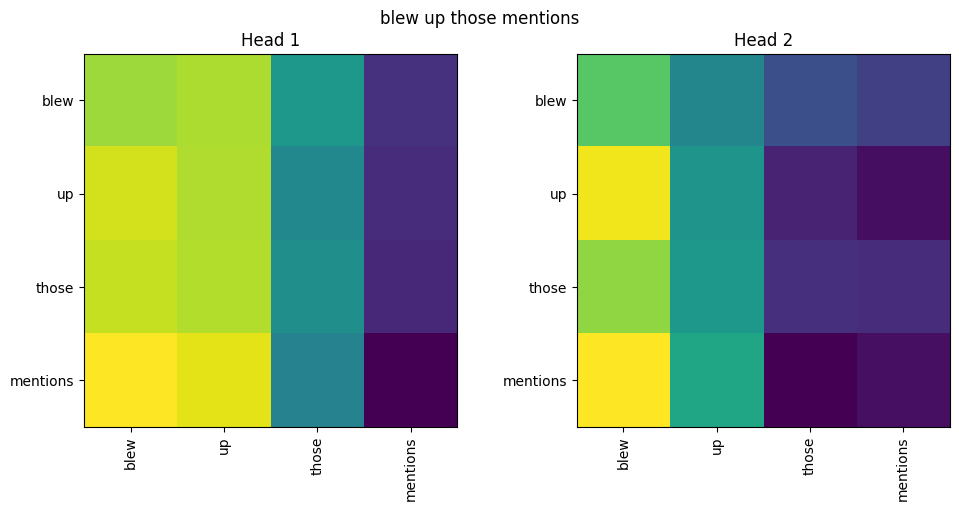

In [ ]:
original_sentence = 'blew up those mentions'
text_sentences = sequences_to_text(format_sentence(original_sentence), tokenizer)
print(text_sentences)
text_sentences[0]
print(original_sentence)
prediction, attn_scores = forward_and_get_attn_scores(format_sentence(original_sentence), tx_model)
classification(prediction)
plot_attention_scores(attn_scores, text_sentences[0], original_sentence)

lp_model

['blew up those mentions']
blew up those mentions
probability of true:  tf.Tensor([0.07053924], shape=(1,), dtype=float32)

         FALSE FALSE FALSE FALSE
         FALSE FALSE FALSE FALSE
         FALSE
         FALSE
         FALSE FALSE FALSE FALSE
         FALSEFALSE FALSE FALSE
         FALSE
         FALSE
         FALSE
         FALSE
         FALSE


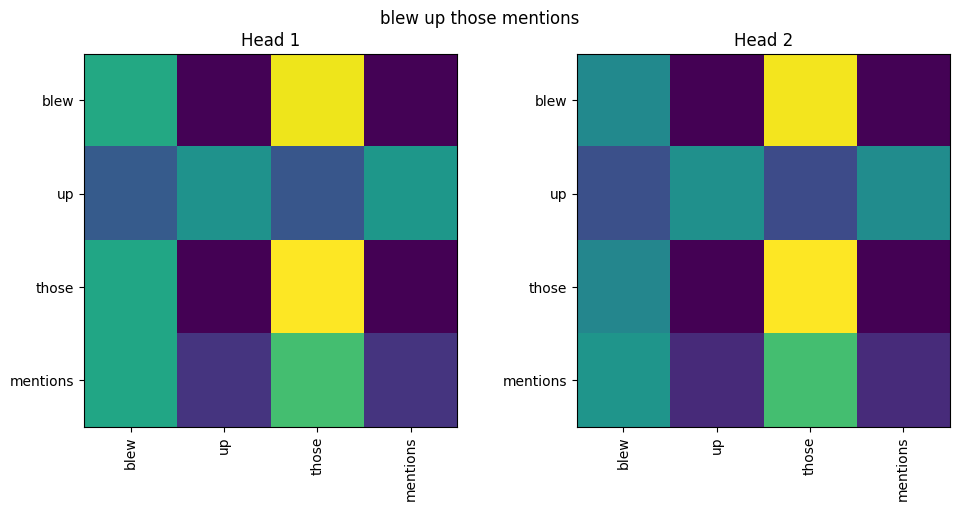

In [ ]:
original_sentence = 'blew up those mentions'
text_sentences = sequences_to_text(format_sentence(original_sentence), tokenizer)
print(text_sentences)
text_sentences[0]
print(original_sentence)
prediction, attn_scores = forward_and_get_attn_scores(format_sentence(original_sentence), lp_model)
classification(prediction)
plot_attention_scores(attn_scores, text_sentences[0], original_sentence)

The above shows a more nuanced view by the lp_model, as the high and lows are of a bigger range and the checkerboard pattern reflects a more nuanced view for each word.

####Formatting Words Font Size per Attention
The following code provides a visual correlation of the font size and the attention given to it.

In [ ]:
from IPython.core.display import display, HTML

def visualize_attention_scores(attn_scores, sentence):
    # Assuming attn_scores is of shape (1, num_heads, seq_len, seq_len)
    num_heads = attn_scores.shape[1]
    seq_len = attn_scores.shape[2]

    # Reshape attention scores to (num_heads, seq_len, seq_len)
    attn_scores1 = np.squeeze(attn_scores, axis=0)

    # Split the sentence into words
    words = sentence.split()

    # Get the length of the sentence
    sentence_length = len(words)

    # Slice the attention scores to match the sentence length
    attn_scores1 = attn_scores1[:, :sentence_length, :sentence_length]

    # Sum the attention scores for each word for each head
    attn_sum = np.sum(attn_scores1, axis=2)

    # Normalize the attention scores to the range [12, 36]
    attn_sum = 12 + 24 * (attn_sum - np.min(attn_sum)) / (np.max(attn_sum) - np.min(attn_sum))

    # Create a list to store the HTML strings for each head
    html_strings = []

    # Iterate over each head
    for i in range(num_heads):
        # Create an HTML string for the current head
        html_string = f"<h2>Head {i+1}</h2><p>"
        # Iterate over each word in the sentence
        for j in range(sentence_length):
            # Add the current word to the HTML string with a font size proportional to its attention score
            html_string += f'<span style="font-size: {attn_sum[i, j]}px">{words[j]}</span> '
        # Close the paragraph tag
        html_string += "</p>"
        # Add the HTML string for the current head to the list
        html_strings.append(html_string)

    # Join the HTML strings for all heads and return the result
    html_output = "".join(html_strings)

    # Display the HTML output inline in Jupyter notebook
    display(HTML(html_output))

# Now you can call the function with attn_scores and sentence as arguments
# visualize_attention_scores(attn_scores, "This is a real tragedy")
    return attn_sum #returned normalized attention scores for sentence

In [ ]:
import numpy as np
from IPython.core.display import display, HTML

def visualize_average_attention_scores(attn_scores, sentence, power=4, font_size_min=12, font_size_max=48):
    # Assuming attn_scores is of shape (1, num_heads, seq_len, seq_len)
    num_heads = attn_scores.shape[1]
    seq_len = attn_scores.shape[2]

    # Reshape attention scores to (num_heads, seq_len, seq_len)
    attn_scores = np.squeeze(attn_scores, axis=0)

    # Split the sentence into words
    words = sentence.split()

    # Get the length of the sentence
    sentence_length = len(words)

    # Slice the attention scores to match the sentence length
    attn_scores = attn_scores[:, :sentence_length, :sentence_length]

    # Sum the attention scores for each word across all heads
    attn_sum = np.sum(attn_scores, axis=0)

    # Average the attention scores for each word
    attn_avg = attn_sum / num_heads

    # Apply a power law transformation to amplify differences
    attn_avg = np.power(attn_avg, power)

    # Normalize the attention scores to the new font size range
    epsilon = 1e-9  # Small value to prevent division by zero
    attn_avg = font_size_min + (font_size_max - font_size_min) * (attn_avg - np.min(attn_avg)) / (np.max(attn_avg) - np.min(attn_avg) + epsilon)

    # Create an HTML string for the sentence
    html_string = "<p>"
    # Iterate over each word in the sentence
    for j in range(sentence_length):
        # Add the current word to the HTML string with a font size proportional to its average attention score
        html_string += f'<span style="font-size: {attn_avg[j]}px">{words[j]}</span> '
    # Close the paragraph tag
    html_string += "</p>"

    # Display the HTML output inline in Jupyter notebook
    display(HTML(html_string))

    # Return the normalized average attention scores for sentence
    return attn_avg

# Example usage:
# attn_scores = np.random.rand(1, 12, 10, 10)  # Replace with actual attention scores
# sentence = "This is a real tragedy"
# visualize_average_attention_scores(attn_scores, sentence)


Below we look at the sentence: 'location forest fire near la ronge sask canada neutral news social concern non irony fear' which was classified incorrectly by the bl_model

bl_model

In [ ]:
sentence ='location forest fire near la ronge sask canada neutral news social concern non irony fear'
prediction, attn_scores = forward_and_get_attn_scores(format_sentence(sentence), bl_model)
classification(prediction)
_ = visualize_attention_scores(attn_scores, sentence)


probability of true:  tf.Tensor([0.44472238], shape=(1,), dtype=float32)

         FALSE FALSE FALSE FALSE
         FALSE FALSE FALSE FALSE
         FALSE
         FALSE
         FALSE FALSE FALSE FALSE
         FALSEFALSE FALSE FALSE
         FALSE
         FALSE
         FALSE
         FALSE
         FALSE


tx_model

In [ ]:
sentence ='location forest fire near la ronge sask canada neutral news social concern non irony fear'
prediction, attn_scores = forward_and_get_attn_scores(format_sentence(sentence), tx_model)
classification(prediction)
_ = visualize_attention_scores(attn_scores, sentence)


probability of true:  tf.Tensor([0.6348514], shape=(1,), dtype=float32)

        TRUE TRUE TRUE TRUE TRUE TRUE
        TRUE TRUE TRUE TRUE TRUE TRUE
        TRUE TRUE TRUE TRUE TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE


lp_model

In [ ]:
sentence ='location forest fire near la ronge sask canada neutral news social concern non irony fear'
prediction, attn_scores = forward_and_get_attn_scores(format_sentence(sentence), lp_model)
classification(prediction)
_ = visualize_attention_scores(attn_scores, sentence)

probability of true:  tf.Tensor([0.98448926], shape=(1,), dtype=float32)

        TRUE TRUE TRUE TRUE TRUE TRUE
        TRUE TRUE TRUE TRUE TRUE TRUE
        TRUE TRUE TRUE TRUE TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE


The probability output of lp_model was 0.98448926 vs the tx_model of 0.6348514, which means the lp_model understands the sentence better.

###Word Embeddings

####Load Embeddings After Training

We expect a (total words, dimensional embedding) shaped matrix

In [53]:
lp_embeddings_after_training = lp_model.encoder.pos_embedding.embedding.get_weights()[0]
tx_embeddings_after_training = tx_model.encoder.pos_embedding.embedding.get_weights()[0]
bl_embeddings_after_training = bl_model.encoder.pos_embedding.embedding.get_weights()[0]


In [54]:
print(lp_embeddings_after_training.shape), print(tx_embeddings_after_training.shape)

(17984, 100)
(17984, 100)


(None, None)

####word_index

In [55]:

word_index = tokenizer.word_index

In [136]:
disaster_words ="""
fire
disaster
emergency
burning
police
bomb
people
news
storm
body
crash
suicide
buildings
death
home
collapse
mass
fear
typhoon
nuclear
attack
hiroshima
killed
families
watch
shit
dead
war
bombing
help
fatal
wildfire
forest
thunder
fires
accident
god
"""
disaster_words_list = disaster_words.strip().split("\n")

disaster words list plotted on the retrieved word embeddings from lp_model

In [137]:
# Import the necessary libraries
from sklearn.manifold import TSNE
import plotly.express as px

# Get the embeddings for the disaster words
embeddings = np.array([lp_embeddings_after_training[word_index[word]] for word in disaster_words_list if word in word_index])

# Use t-SNE to reduce the dimensionality of the embeddings
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

# Create a DataFrame with the 2D embeddings and the words
embeddings_df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
embeddings_df['word'] = disaster_words_list

# Add index column to the DataFrame
embeddings_df['index'] = embeddings_df.index

# Create an interactive plot
fig = px.scatter(embeddings_df, x='x', y='y', hover_data=['word', 'index'], text='word')

# Update layout to show text
fig.update_traces(textposition='top center')

fig.show()


disaster words list plotted on the retrieved word embeddings from tx_model

In [138]:
# Import the necessary libraries
from sklearn.manifold import TSNE
import plotly.express as px

# Get the embeddings for the disaster words
embeddings = np.array([tx_embeddings_after_training[word_index[word]] for word in disaster_words_list if word in word_index])

# Use t-SNE to reduce the dimensionality of the embeddings
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

# Create a DataFrame with the 2D embeddings and the words
embeddings_df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
embeddings_df['word'] = disaster_words_list

# Add index column to the DataFrame
embeddings_df['index'] = embeddings_df.index

# Create an interactive plot
fig = px.scatter(embeddings_df, x='x', y='y', hover_data=['word', 'index'], text='word')

# Update layout to show text
fig.update_traces(textposition='top center')

fig.show()


####Load Pre-Trained Embeddings

In [56]:
# Load the embeddings from the CSV file
path_to_embeddings = 'fast_text_twitter_embeddings.csv'
loaded_embeddings_df = pd.read_csv(path_to_embeddings)
loaded_embeddings = loaded_embeddings_df.values

Load Initial (Random) Embeddings for Baseline model

In [57]:
# Load the embeddings from the CSV file
bl_path_to_embeddings = './Final_Work/enhanced_cleaned_data_base_tx_4_heads/initial_embeddings.csv'
bl_loaded_embeddings_df = pd.read_csv(path_to_embeddings)
bl_loaded_embeddings = loaded_embeddings_df.values

Loaded Embeddings from lp_model plotted againts the pre-train embeddings

In [139]:
# Import the necessary libraries
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px


# Assuming embeddings_after_training is already defined as shown in your message

# Get the embeddings for the disaster words from both sets
loaded_embeddings_subset = np.array([loaded_embeddings[word_index[word]] for word in disaster_words_list if word in word_index])
trained_embeddings_subset = np.array([lp_embeddings_after_training[word_index[word]] for word in disaster_words_list  if word in word_index])

# Combine both sets of embeddings
combined_embeddings = np.vstack((loaded_embeddings_subset, trained_embeddings_subset))

# Use t-SNE to reduce the dimensionality of the combined embeddings
tsne = TSNE(n_components=2, random_state=0)
combined_embeddings_2d = tsne.fit_transform(combined_embeddings)

# Create a DataFrame with the 2D embeddings and the words
embeddings_df = pd.DataFrame(combined_embeddings_2d, columns=['x', 'y'])
embeddings_df['word'] = disaster_words_list * 2  # Repeat words for both sets

# Add a column to distinguish between the two sets
embeddings_df['set'] = ['Loaded'] * len(loaded_embeddings_subset) + ['Trained'] * len(trained_embeddings_subset)

# Create an interactive plot
fig = px.scatter(embeddings_df, x='x', y='y', color='set', hover_data=['word'], text='word')

# Update layout to show text
fig.update_traces(textposition='top center')

# Show the plot
fig.show()


Notably above, wildifires, families, and killed, changed the most.

####Compare A Sentence in Two Different Embeddings - 2D plots

####Plot Compare Embeddings

In [60]:
# Import the necessary libraries

from sklearn.manifold import TSNE
import plotly.express as px



def plot_compare_embeddings(sentences, loaded_embeddings, embeddings_after_training, word_index):
    # Check if the input is a single string, if so, convert it to a list
    if isinstance(sentences, str):
        sentences = [sentences]

    # Initialize an empty list to store processed words
    disaster_words_list = []

    # Process each sentence in the list
    for sentence in sentences:
        # Split the sentence into words and extend the processed words list
        disaster_words_list.extend(sentence.lower().split())

    # Get the embeddings for the words in the sentence from both sets
    loaded_embeddings_subset = np.array([loaded_embeddings[word_index[word]] for word in disaster_words_list if word in word_index])
    trained_embeddings_subset = np.array([embeddings_after_training[word_index[word]] for word in disaster_words_list if word in word_index])

    # Combine both sets of embeddings
    combined_embeddings = np.vstack((loaded_embeddings_subset, trained_embeddings_subset))

    # Use t-SNE to reduce the dimensionality of the combined embeddings
    #disaster_words_list = sentence.split()
    sentence_length = len(disaster_words_list)
    tsne = TSNE(n_components=2, random_state=0, perplexity=min(30, sentence_length - 1))
    #tsne = TSNE(n_components=2, random_state=0)
    combined_embeddings_2d = tsne.fit_transform(combined_embeddings)

    # Create a DataFrame with the 2D embeddings and the words
    embeddings_df = pd.DataFrame(combined_embeddings_2d, columns=['x', 'y'])
    embeddings_df['word'] = disaster_words_list * 2  # Repeat words for both sets


    # Correct the length of the 'word' column to match the DataFrame's index
    embeddings_df = embeddings_df.loc[embeddings_df.index.repeat(2)].reset_index(drop=True)

    # Add a column to distinguish between the two sets
    embeddings_df['set'] = ['Loaded'] * len(loaded_embeddings_subset) + ['Trained'] * len(trained_embeddings_subset)
    # Define the color map for the sets
    color_discrete_map = {'Loaded': 'red', 'Trained': 'blue'}

    # Create an interactive plot
    fig = px.scatter(embeddings_df, x='x', y='y', color='set', hover_data=['word'], text='word', color_discrete_map=color_discrete_map)



    # Update layout to show text
    #fig.update_traces(textposition='top center')
    fig.update_traces(textposition='top center', marker=dict(size=12), textfont_size=16)
    # Show the plot
    fig.show()




In [70]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px

def plot_compare_embeddings(sentences, loaded_embeddings, embeddings_after_training, word_index):
    # Check if the input is a single string, if so, convert it to a list
    if isinstance(sentences, str):
        sentences = [sentences]

    # Initialize an empty list to store processed words
    disaster_words_list = []

    # Process each sentence in the list
    for sentence in sentences:
        # Split the sentence into words and extend the processed words list
        disaster_words_list.extend(sentence.lower().split())

    # Get the embeddings for the words in the sentence from both sets
    loaded_embeddings_subset = np.array([loaded_embeddings[word_index[word]] for word in disaster_words_list if word in word_index])
    trained_embeddings_subset = np.array([embeddings_after_training[word_index[word]] for word in disaster_words_list if word in word_index])

    # Combine both sets of embeddings
    combined_embeddings = np.vstack((loaded_embeddings_subset, trained_embeddings_subset))

    # Use t-SNE to reduce the dimensionality of the combined embeddings
    sentence_length = len(disaster_words_list)
    tsne = TSNE(n_components=2, random_state=0, perplexity=min(30, sentence_length - 1))
    combined_embeddings_2d = tsne.fit_transform(combined_embeddings)

    # Create a DataFrame with the 2D embeddings and the words
    embeddings_df = pd.DataFrame(combined_embeddings_2d, columns=['x', 'y'])

    # Repeat words for both sets and ensure the length matches the number of rows in the DataFrame
    embeddings_df['word'] = disaster_words_list * (len(loaded_embeddings_subset) + len(trained_embeddings_subset)) // len(disaster_words_list)

    # Add a column to distinguish between the two sets
    embeddings_df['set'] = ['Loaded'] * len(loaded_embeddings_subset) + ['Trained'] * len(trained_embeddings_subset)

    # Define the color map for the sets
    color_discrete_map = {'Loaded': 'red', 'Trained': 'blue'}

    # Create an interactive plot
    fig = px.scatter(embeddings_df, x='x', y='y', color='set', hover_data=['word'], text='word', color_discrete_map=color_discrete_map)

    # Update layout to show text
    fig.update_traces(textposition='top center', marker=dict(size=12), textfont_size=16)

    # Show the plot
    fig.show()




In [72]:
def plot_compare_embeddings(sentences, loaded_embeddings, embeddings_after_training, word_index):
    # Check if the input is a single string, if so, convert it to a list
    if isinstance(sentences, str):
        sentences = [sentences]

    # Initialize an empty list to store processed words
    disaster_words_list = []

    # Process each sentence in the list
    for sentence in sentences:
        # Split the sentence into words and extend the processed words list
        disaster_words_list.extend(sentence.lower().split())

    # Get the embeddings for the words in the sentence from both sets
    loaded_embeddings_subset = np.array([loaded_embeddings[word_index[word]] for word in disaster_words_list if word in word_index])
    trained_embeddings_subset = np.array([embeddings_after_training[word_index[word]] for word in disaster_words_list if word in word_index])

    # Combine both sets of embeddings
    combined_embeddings = np.vstack((loaded_embeddings_subset, trained_embeddings_subset))

    # Use t-SNE to reduce the dimensionality of the combined embeddings
    sentence_length = len(disaster_words_list)
    tsne = TSNE(n_components=2, random_state=0, perplexity=min(30, sentence_length - 1))
    combined_embeddings_2d = tsne.fit_transform(combined_embeddings)

    # Create a DataFrame with the 2D embeddings and the words
    embeddings_df = pd.DataFrame(combined_embeddings_2d, columns=['x', 'y'])

    # Calculate the number of times to repeat the disaster_words_list
    repeat_times = (len(loaded_embeddings_subset) + len(trained_embeddings_subset)) // len(disaster_words_list)

    # Repeat words for both sets and ensure the length matches the number of rows in the DataFrame
    embeddings_df['word'] = disaster_words_list * repeat_times

    # Add a column to distinguish between the two sets
    embeddings_df['set'] = ['Loaded'] * len(loaded_embeddings_subset) + ['Trained'] * len(trained_embeddings_subset)

    # Define the color map for the sets
    color_discrete_map = {'Loaded': 'red', 'Trained': 'blue'}

    # Create an interactive plot
    fig = px.scatter(embeddings_df, x='x', y='y', color='set', hover_data=['word'], text='word', color_discrete_map=color_discrete_map)

    # Update layout to show text
    fig.update_traces(textposition='top center', marker=dict(size=12), textfont_size=16)

    # Show the plot
    fig.show()


In [75]:
def plot_compare_embeddings(sentences, loaded_embeddings, embeddings_after_training, word_index):
    # Check if the input is a single string, if so, convert it to a list
    if isinstance(sentences, str):
        sentences = [sentences]

    # Initialize an empty list to store processed words
    disaster_words_list = []

    # Process each sentence in the list
    for sentence in sentences:
        # Split the sentence into words and extend the processed words list
        disaster_words_list.extend(sentence.lower().split())

    # Initialize lists to store the embeddings and labels
    combined_embeddings = []
    words = []
    labels = []

    # Get the embeddings for the words in the sentence from both sets and label them
    for word in disaster_words_list:
        if word in word_index:
            loaded_embedding = loaded_embeddings[word_index[word]]
            trained_embedding = embeddings_after_training[word_index[word]]
            combined_embeddings.extend([loaded_embedding, trained_embedding])
            words.extend([word, word])
            labels.extend(['Loaded', 'Trained'])

    # Use t-SNE to reduce the dimensionality of the combined embeddings
    tsne = TSNE(n_components=2, random_state=0)
    combined_embeddings_2d = tsne.fit_transform(np.array(combined_embeddings))

    # Create a DataFrame with the 2D embeddings, words, and labels
    embeddings_df = pd.DataFrame(combined_embeddings_2d, columns=['x', 'y'])
    embeddings_df['word'] = words
    embeddings_df['label'] = labels

    # Define the color map for the labels
    color_discrete_map = {'Loaded': 'red', 'Trained': 'blue'}

    # Create an interactive plot
    fig = px.scatter(embeddings_df, x='x', y='y', color='label', hover_data=['word'], text='word', color_discrete_map=color_discrete_map)

    # Update layout to show text
    fig.update_traces(textposition='top center', marker=dict(size=12), textfont_size=16)

    # Show the plot
    fig.show()


In [77]:
def plot_compare_embeddings(sentences, loaded_embeddings, embeddings_after_training, word_index):
    # Check if the input is a single string, if so, convert it to a list
    if isinstance(sentences, str):
        sentences = [sentences]

    # Initialize an empty list to store processed words
    disaster_words_list = []

    # Process each sentence in the list
    for sentence in sentences:
        # Split the sentence into words and extend the processed words list
        disaster_words_list.extend(sentence.lower().split())

    # Initialize lists to store the embeddings and labels
    combined_embeddings = []
    words = []
    labels = []

    # Get the embeddings for the words in the sentence from both sets and label them
    for word in disaster_words_list:
        if word in word_index:
            loaded_embedding = loaded_embeddings[word_index[word]]
            trained_embedding = embeddings_after_training[word_index[word]]
            combined_embeddings.extend([loaded_embedding, trained_embedding])
            words.extend([word, word])
            labels.extend(['Loaded', 'Trained'])

    # Use t-SNE to reduce the dimensionality of the combined embeddings
    # Set perplexity to a value less than the number of samples
    perplexity_value = min(len(combined_embeddings) - 1, 30)
    tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity_value)
    combined_embeddings_2d = tsne.fit_transform(np.array(combined_embeddings))

    # Create a DataFrame with the 2D embeddings, words, and labels
    embeddings_df = pd.DataFrame(combined_embeddings_2d, columns=['x', 'y'])
    embeddings_df['word'] = words
    embeddings_df['label'] = labels

    # Define the color map for the labels
    color_discrete_map = {'Loaded': 'red', 'Trained': 'blue'}

    # Create an interactive plot
    fig = px.scatter(embeddings_df, x='x', y='y', color='label', hover_data=['word'], text='word', color_discrete_map=color_discrete_map)

    # Update layout to show text
    fig.update_traces(textposition='top center', marker=dict(size=12), textfont_size=16)

    # Show the plot
    fig.show()


In [82]:
def plot_compare_embeddings(sentences, loaded_embeddings, embeddings_after_training, word_index):
    # Check if the input is a single string, if so, convert it to a list
    if isinstance(sentences, str):
        sentences = [sentences]

    # Initialize an empty list to store processed words
    disaster_words_list = []

    # Process each sentence in the list
    for sentence in sentences:
        # Split the sentence into words and extend the processed words list
        disaster_words_list.extend(sentence.lower().split())

    # Remove duplicates by converting the list to a set, then back to a list
    disaster_words_list = list(set(disaster_words_list))

    # Initialize lists to store the embeddings and labels
    combined_embeddings = []
    words = []
    labels = []

    # Get the embeddings for the words in the sentence from both sets and label them
    for word in disaster_words_list:
        if word in word_index:
            loaded_embedding = loaded_embeddings[word_index[word]]
            trained_embedding = embeddings_after_training[word_index[word]]
            combined_embeddings.append(loaded_embedding)
            combined_embeddings.append(trained_embedding)
            words.append(word)
            words.append(word)
            labels.append('Loaded')
            labels.append('Trained')

    # Use t-SNE to reduce the dimensionality of the combined embeddings
    # Set perplexity to a value less than the number of samples
    perplexity_value = min(len(disaster_words_list) * 2 - 1, 30)
    tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity_value)
    combined_embeddings_2d = tsne.fit_transform(np.array(combined_embeddings))

    # Create a DataFrame with the 2D embeddings, words, and labels
    embeddings_df = pd.DataFrame(combined_embeddings_2d, columns=['x', 'y'])
    embeddings_df['word'] = words
    embeddings_df['label'] = labels

    # Define the color map for the labels
    color_discrete_map = {'Loaded': 'red', 'Trained': 'blue'}

    # Create an interactive plot
    fig = px.scatter(embeddings_df, x='x', y='y', color='label', hover_data=['word'], text='word', color_discrete_map=color_discrete_map)

    # Update layout to show text
    fig.update_traces(textposition='top center', marker=dict(size=12), textfont_size=16)

    # Show the plot
    fig.show()



In [86]:
def plot_compare_embeddings(sentences, loaded_embeddings, embeddings_after_training, word_index):
    # Check if the input is a single string, if so, convert it to a list
    if isinstance(sentences, str):
        sentences = [sentences]

    # Initialize an empty list to store processed words
    disaster_words_list = []

    # Process each sentence in the list
    for sentence in sentences:
        # Split the sentence into words and extend the processed words list
        disaster_words_list.extend(sentence.lower().split())

    # Remove duplicates by converting the list to a set, then back to a list
    disaster_words_list = list(set(disaster_words_list))

    # Initialize lists to store the embeddings and labels
    combined_embeddings = []
    words = []
    labels = []

    # Get the embeddings for the words in the sentence from both sets and label them
    for word in disaster_words_list:
        if word in word_index:
            loaded_embedding = loaded_embeddings[word_index[word]]
            trained_embedding = embeddings_after_training[word_index[word]]
            combined_embeddings.append(loaded_embedding)
            combined_embeddings.append(trained_embedding)
            words.append(word)
            words.append(word)
            labels.append('Loaded')
            labels.append('Trained')

    # Use t-SNE to reduce the dimensionality of the combined embeddings
    # Ensure perplexity is less than the number of unique word embeddings
    sentence_length = len(disaster_words_list)
    tsne = TSNE(n_components=2, random_state=0, perplexity=min(30, sentence_length - 1))
    #perplexity_value = min(len(combined_embeddings) // 2 - 1, 30)
    #tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity_value)
    combined_embeddings_2d = tsne.fit_transform(np.array(combined_embeddings))

    # Create a DataFrame with the 2D embeddings, words, and labels
    embeddings_df = pd.DataFrame(combined_embeddings_2d, columns=['x', 'y'])
    embeddings_df['word'] = words
    embeddings_df['label'] = labels

    # Define the color map for the labels
    color_discrete_map = {'Loaded': 'red', 'Trained': 'blue'}

    # Create an interactive plot
    fig = px.scatter(embeddings_df, x='x', y='y', color='label', hover_data=['word'], text='word', color_discrete_map=color_discrete_map)

    # Update layout to show text
    fig.update_traces(textposition='top center', marker=dict(size=12), textfont_size=16)

    # Show the plot
    fig.show()




####Nearest N-Neighboor Embeddings 2D Plot

In [92]:
# Import the necessary libraries
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

# Define the function
def plot_nearest_n(sentences, embeddings_after_training, word_index, n_nearest, loaded_model='None'):
    # Check if the input is a single string, if so, convert it to a list
    if isinstance(sentences, str):
        sentences = [sentences]

    # Initialize an empty list to store processed words
    disaster_words_list = []

    # Process each sentence in the list
    for sentence in sentences:
        # Split the sentence into words and extend the processed words list
        disaster_words_list.extend(sentence.lower().split())

    # Create a reverse mapping from indices to words
    index_word = {v: k for k, v in word_index.items()}

    # Get the embeddings for the words in the sentence
    sentence_embeddings = [embeddings_after_training[word_index[word]] for word in disaster_words_list if word in word_index]

    # Fit the NearestNeighbors model on the entire embeddings
    nn = NearestNeighbors(n_neighbors=n_nearest + 1).fit(embeddings_after_training)

    # Find the n nearest neighbors for each word embedding in the sentence
    neighbors_dict = {}
    for word in disaster_words_list:
        if word in word_index:
            word_embedding = embeddings_after_training[word_index[word]]
            _, indices = nn.kneighbors([word_embedding])
            neighbors_dict[word] = [index_word[idx] for idx in indices.flatten()[1:] if idx in index_word]

    # Use t-SNE to reduce the dimensionality of the entire embeddings
    tsne = TSNE(n_components=2, random_state=0)
    # Wrap the fit_transform with tqdm for a progress bar
    embeddings_2d = tsne.fit_transform(np.array(list(tqdm(embeddings_after_training[:-1], desc='t-SNE Progress'))))

    # Create a DataFrame for the t-SNE embeddings
    # Adjust the index range to match the number of embeddings
    tsne_df = pd.DataFrame(embeddings_2d, index=[index_word[i] for i in range(1, len(embeddings_2d) +1 )], columns=['x', 'y'])
    tsne_df['word'] = tsne_df.index
    tsne_df['color'] = 'gray'  # Default color for all words




    # Initialize a set to store the words to be plotted
    words_to_plot = set()

    # Update colors for sentence words and their neighbors
    for word, neighbors in neighbors_dict.items():
      if word in word_index:
        words_to_plot.add(word)
        tsne_df.loc[word, 'color'] = 'blue'  # Color the sentence words in blue
        for neighbor in neighbors:
          words_to_plot.add(neighbor)
          if neighbor in tsne_df.index:
            tsne_df.loc[neighbor, 'color'] = 'red'  # Color the neighbors in red
    # Filter the DataFrame to only include the words to be plotted

    words_to_plot_list = list(words_to_plot)
    tsne_df = tsne_df.loc[words_to_plot_list]

    # Create an interactive plot
    fig = px.scatter(tsne_df, x='x', y='y', color='color', hover_data=['word'], text='word')

   # Update layout to show text and add title
    fig.update_traces(textposition='top center', marker=dict(size=12), textfont_size=16)
    title_text = f'{n_nearest} Nearest Neighbors' if loaded_model == 'None' else f'model: {loaded_model} \n {n_nearest} Nearest Neighbors'
    fig.update_layout(title={'text': title_text, 'y':0.9, 'x':0.25, 'xanchor': 'center', 'yanchor': 'top'})

    # Add custom legend
    fig.update_layout(legend_title_text='Legend')
    fig.for_each_trace(lambda t: t.update(name = 'Nearest Neighbor' if t.name == 'red' else 'Word'))

    # Add legend to the right
    fig.update_layout(legend=dict(
        orientation="v",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ))

    # Show the plot
    fig.show()




Here we analyze the bl_model semantic understanding of 'mentions', and see the nearest words around it.

In [ ]:
plot_nearest_n("blew up those mentions", bl_embeddings_after_training, word_index, 3, 'bl_model')

t-SNE Progress: 100%|██████████| 17983/17983 [00:00<00:00, 1620360.67it/s]


In [ ]:
plot_nearest_n("blew up those mentions", tx_embeddings_after_training, word_index, 3, 'tx_model')

t-SNE Progress: 100%|██████████| 17983/17983 [00:00<00:00, 1104384.80it/s]


In [ ]:
plot_nearest_n("blew up those mentions", lp_embeddings_after_training, word_index, 3, 'lp_model')

t-SNE Progress: 100%|██████████| 17983/17983 [00:00<00:00, 1483365.50it/s]


The above results show that the bl_model did not have the right fine tuned semantic meaning of 'mentions', where as the lp_model 'mentions' is farthest away from 'comments' than in the tx_model. This means the lp_model fine tuned the words based on the dataset more than the tx_model. This naturally leads us to enquire what are top changed words after training for each model, and if one is obviously better than the other.

####Top n Changed Words After Training
for the following plot you need to have the before and after embeddings

In [93]:


def top_changed_embeddings(loaded_embeddings, trained_embeddings, word_index, top_n=10):
    # Calculate the differences between the two sets of embeddings
    differences = {}
    for word, index in word_index.items():
        if index < len(loaded_embeddings) and index < len(trained_embeddings):
            differences[word] = np.linalg.norm(loaded_embeddings[index] - trained_embeddings[index])

    # Sort the words by the largest changes
    sorted_words = sorted(differences, key=differences.get, reverse=True)

    # Get the top N words with the most change
    top_words = sorted_words[:top_n]

    # Return the top N words and their corresponding differences
    return [(word, differences[word]) for word in top_words]




In [94]:
tx_disaster_words = top_changed_embeddings(loaded_embeddings, tx_embeddings_after_training, word_index)
tx_disaster_words_list = [item[0] for item in tx_disaster_words]
tx_disaster_words

[('suicide', 0.2542814085893426),
 ('hiroshima', 0.2366639098735998),
 ('derailment', 0.23234185947136063),
 ('positive', 0.2134087088705059),
 ('california', 0.21303300061344782),
 ('bombing', 0.21094468542664885),
 ('debris', 0.21006077369589732),
 ('wildfire', 0.20714493198224423),
 ('killed', 0.200944669891897),
 ('northern', 0.19962536227301594)]

In [95]:
lp_disaster_words = top_changed_embeddings(loaded_embeddings, lp_embeddings_after_training, word_index)
lp_disaster_words_list = [item[0] for item in lp_disaster_words]
lp_disaster_words

[('hiroshima', 0.496638707030925),
 ('spill', 0.4849229581973467),
 ('suicide', 0.448507128728351),
 ('bomb', 0.4369772545959775),
 ('derailment', 0.4233027778885434),
 ('northern', 0.4181329351044703),
 ('california', 0.4133995836162507),
 ('atomic', 0.40671896164405086),
 ('killed', 0.39854748212169594),
 ('wreckage', 0.3949224709598692)]

The above results show that the embeddings trained with lp_model moved on average more (0.45) than by the tx_model(0.22). The two lists are very similar.

Calculate how much from a list of words have changed

In [99]:
disaster_words ="""
fire
disaster
emergency
burning
police
bomb
people
news
storm
body
crash
suicide
buildings
death
home
collapse
mass
fear
typhoon
nuclear
attack
hiroshima
killed
families
watch
shit
dead
war
bombing
help
fatal
wildfire
forest
thunder
fires
accident
god
"""
disaster_words_list = disaster_words.strip().split("\n")

####Top n Words Changed from a Word List

In [101]:
import numpy as np

def top_word_changed_embeddings(loaded_embeddings, trained_embeddings, word_index, words_list, top_n=10):
    # Calculate the differences between the two sets of embeddings for the given list of words
    differences = {}
    for word in words_list:
        index = word_index.get(word)
        if index is not None and index < len(loaded_embeddings) and index < len(trained_embeddings):
            differences[word] = np.linalg.norm(loaded_embeddings[index] - trained_embeddings[index])

    # Sort the words by the largest changes
    sorted_words = sorted(differences, key=differences.get, reverse=True)

    # Get the top N words with the most change
    top_words = sorted_words[:top_n]

    # Return the top N words and their corresponding differences
    return top_words, [(word, differences[word]) for word in top_words]




In [126]:
tx_disaster_list, top_words = top_word_changed_embeddings(loaded_embeddings, \
                                                          tx_embeddings_after_training, word_index, disaster_words_list)



In [127]:
top_words

[('suicide', 0.2542814085893426),
 ('hiroshima', 0.2366639098735998),
 ('bombing', 0.21094468542664885),
 ('wildfire', 0.20714493198224423),
 ('killed', 0.200944669891897),
 ('typhoon', 0.193992721950032),
 ('bomb', 0.18714145221705575),
 ('families', 0.15679069326693082),
 ('body', 0.13875680339463148),
 ('attack', 0.12125044385997531)]

In [128]:
lp_disaster_list, top_words = top_word_changed_embeddings(loaded_embeddings,\
                                                          lp_embeddings_after_training, word_index, disaster_words_list)

In [129]:
top_words

[('hiroshima', 0.496638707030925),
 ('suicide', 0.448507128728351),
 ('bomb', 0.4369772545959775),
 ('killed', 0.39854748212169594),
 ('bombing', 0.37386424673313806),
 ('typhoon', 0.3667053370593496),
 ('wildfire', 0.30783158195214544),
 ('mass', 0.3049600095316895),
 ('families', 0.28411852434789686),
 ('fear', 0.26975122736083657)]

In [133]:
happy_word_list=['television', 'game', 'music', 'crash', 'accident']

In [134]:
lp_disaster_list, top_words = top_word_changed_embeddings(loaded_embeddings,\
                                                          lp_embeddings_after_training, word_index, happy_word_list)
top_words

[('accident', 0.23368874616599758),
 ('music', 0.18602782096539075),
 ('crash', 0.12003486196187114),
 ('game', 0.10377270085271638)]

In [135]:
tx_disaster_list, top_words = top_word_changed_embeddings(loaded_embeddings,\
                                                          tx_embeddings_after_training, word_index, happy_word_list)
top_words

[('accident', 0.09295402109377758),
 ('music', 0.07539183339476341),
 ('crash', 0.07383608751385635),
 ('game', 0.055367876614340485)]

The above only re-states the same results. The lp_model made more changes to the words on the happy list then the tx_model.

<bold>In conclusion, the lp_model, beyond val_accuracy scores, should be able to generalize more, if provided with more data, when compared to the tx_model. </bold>

##Appendix

####Attention Scores and the Embedded Vectors Combined

In [107]:
def attention_scores_normalized(attn_scores, sentence):
    # Assuming attn_scores is of shape (1, num_heads, seq_len, seq_len)
    num_heads = attn_scores.shape[1]
    seq_len = attn_scores.shape[2]

    # Reshape attention scores to (num_heads, seq_len, seq_len)
    attn_scores1 = np.squeeze(attn_scores, axis=0)

    # Split the sentence into words
    words = sentence.split()

    # Get the length of the sentence
    sentence_length = len(words)

    # Slice the attention scores to match the sentence length
    attn_scores1 = attn_scores1[:, :sentence_length, :sentence_length]

    # Sum the attention scores for each word for each head
    attn_sum = np.sum(attn_scores1, axis=2)

    # Normalize the attention scores to the range [12, 36]
    attn_sum = 12 + 24 * (attn_sum - np.min(attn_sum)) / (np.max(attn_sum) - np.min(attn_sum))

    return attn_sum #returned normalized attention scores for sentence

In [122]:
import plotly.graph_objs as go
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd

# Assuming these functions and variables are defined elsewhere in your code:
# forward_and_get_attn_scores, format_sentence, attention_scores_normalized, embeddings_after_training, word_index

def visualize_attention_scores_2D(sentences, model=tx_model, embeddings_after_training=tx_embeddings_after_training):
    predictions = []
    attn_scores = []
    attn_sums = []
    all_embeddings = []  # Define all_embeddings list

    # Create an interactive plot
    fig = go.Figure()

    # Define colors for the sentences
    colors = ['darkblue', 'darkred', 'darkgreen', 'brown', 'black', 'darkgray', 'steelblue']  # Add more colors if needed

    word_list = []  # List to store all words from all sentences
    color_list = []  # List to store corresponding colors for all words

    for i, sentence in enumerate(sentences):
        prediction, attn_score = forward_and_get_attn_scores(format_sentence(sentence), model)
        predictions.append(prediction)
        attn_scores.append(attn_score)
        attn_sums.append(attention_scores_normalized(attn_score, sentence))

        # Split the sentence into words
        disaster_words_list = sentence.split()

        # Get the embeddings for the disaster words and update word_list and color_list accordingly
        for word in disaster_words_list:
            if word in word_index:
                embeddings = embeddings_after_training[word_index[word]]
                all_embeddings.append(embeddings)
                word_list.append(word)
                color_list.append(colors[i])

    sentence_length = len(word_list)

    # Use t-SNE to reduce the dimensionality of the attention scores
    all_embeddings = [embedding.reshape(1, -1) for embedding in all_embeddings]
    all_embeddings_2d = TSNE(n_components=2, random_state=0, perplexity=min(30, sentence_length - 1)).fit_transform(np.concatenate(all_embeddings, axis=0))

    # Create a DataFrame with the 2D embeddings and the words
    all_embeddings_df = pd.DataFrame(all_embeddings_2d, columns=['x', 'y'])
    all_embeddings_df['word'] = word_list
    all_embeddings_df['color'] = color_list

    # Add scatter trace for points
    fig.add_trace(
    go.Scatter(
        x=all_embeddings_df['x'],
        y=all_embeddings_df['y'],
        mode='markers+text',
        hoverinfo='text',
        hovertext=all_embeddings_df['word'],
        text=all_embeddings_df['word'],
        textposition='top center',
        textfont=dict(
            size=[attn_sums[word_list.index(word)][0] for word in word_list],  # Adjust size based on attention
            color=all_embeddings_df['color']  # color of the text
        )
        )
    )
    fig.show()




#End of File